In [1]:
γr, kr, γp, kp = 1/5,1,1/45,50


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from numba import jit,njit,float64,int32
import numba as nb

In [3]:
@njit('f8[:](f8[:],f8)')
def Gillespie(trp0,tmax):
    
    '''
    Gillespie(trp0, tmax)

    Return a ndarray from the given initial state with the last times, number of mRNA and the last number of proteins.
    
    Parameters
    ----------
    trp0 : array like
        Array like with the initial state of a every single cell. It must be in this order: time,
        number of mRNA, number of proteins.
    tmax : int
        Maximum time to be run in the simulation
    
    Returns
    -------
    out : ndarray
        Array of the last time, number of mRNA and the last number of proteins obtained after the stochastic 
        simulation of a single system.    
    
    '''
    
    t,r,p =trp0 

    while t < tmax:
        s1 = kr
        s2 = γr*r
        s3 = kp*r
        s4 = γp*p
        st = s1+s2+s3+s4
        τ = (-1/st)*np.log(np.random.rand())
        x = np.random.rand()
        if(x< s1/st):
            r+=1
        elif(x<(s1+s2)/st):
            r-=1
        elif(x<(s1+s2+s3)/st):
            p+=1
        else:
            p-=1
        t+=τ
    return np.array([t,r,p]) 

In [4]:
@njit('f8[:,:](f8[:],f8[:])')
def Estado_celula(X0,tiempos):
    '''
    Estado_celula(X0,tiempos)

    Returns a matrix with the evolved genetic expression of a single cell.
    
    Parameters
    ----------
    X0 :ndarray 
        Vector with the system's initial state.
        It has as many rows as elements have tiempos and as many columns as evaluated chemical species.
    tiempos : numpy linspace, ndarray, array like
        Vector containing the sampling times to evolve the system.
    
    Returns
    -------
    out : matrix, 2D ndarray
        2D ndarray with the evolved system data.
    
    Example
    --------
    >>> x0 = np.array([0.0,0.0,0.0])             #time starts in 0.0, number of mRNA starts in 0.0 
                                                 #and number of proteins starts in 0.0, respectively.
                                               
    >>> Estado_celula(x0,np.linspace(0,200,10))  #Evolves a single cell with initial conditions x0 and a
                                                 #equispaced sampling time vector with 10 elements from 
                                                 #0 to 200. We chose only 10 elements for simplicity, but
                                                 #there are 50 by default. 
                                               
    array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [2.22233941e+01, 6.00000000e+00, 4.58400000e+03],
    [4.44470482e+01, 3.00000000e+00, 7.73200000e+03],
    [6.66697353e+01, 5.00000000e+00, 5.90500000e+03],
    [8.88922698e+01, 4.00000000e+00, 5.80100000e+03],
    [1.11113080e+02, 6.00000000e+00, 7.65800000e+03],
    [1.33335290e+02, 7.00000000e+00, 6.79300000e+03],
    [1.55556091e+02, 7.00000000e+00, 1.00870000e+04],
    [1.77778084e+02, 2.00000000e+00, 9.95200000e+03],
    [2.00003693e+02, 3.00000000e+00, 8.36100000e+03]])
    
    Note that the first row is the initial condition vector x0.

    '''
    
    X = np.zeros((len(tiempos),len(X0)))
    X[0] = X0
    
    for i in range(1,len(tiempos)):
        X[i] = Gillespie(X[i-1],tiempos[i])
    
    return X

In [5]:
x0 = np.array([0.,0.,0.])

In [6]:
una_celula = Estado_celula(x0,np.linspace(0,200))
una_celula

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.35768111e+00, 1.00000000e+00, 7.30000000e+01],
       [8.16940864e+00, 2.00000000e+00, 3.25000000e+02],
       [1.22458936e+01, 2.00000000e+00, 8.74000000e+02],
       [1.63293227e+01, 5.00000000e+00, 1.47600000e+03],
       [2.04092531e+01, 5.00000000e+00, 2.38400000e+03],
       [2.44917620e+01, 5.00000000e+00, 3.30400000e+03],
       [2.85746501e+01, 6.00000000e+00, 3.97100000e+03],
       [3.26540086e+01, 6.00000000e+00, 4.85700000e+03],
       [3.67506677e+01, 2.00000000e+00, 5.45300000e+03],
       [4.08178927e+01, 4.00000000e+00, 5.66600000e+03],
       [4.49032682e+01, 5.00000000e+00, 6.02100000e+03],
       [4.89812125e+01, 9.00000000e+00, 7.11300000e+03],
       [5.30631627e+01, 6.00000000e+00, 7.68100000e+03],
       [5.71449760e+01, 8.00000000e+00, 8.11100000e+03],
       [6.12250601e+01, 7.00000000e+00, 8.92800000e+03],
       [6.53065620e+01, 7.00000000e+00, 9.25200000e+03],
       [6.93915818e+01, 3.00000

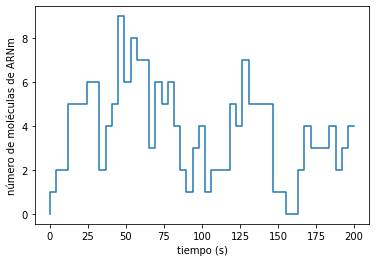

In [7]:
plt.xlabel('tiempo (s)')
plt.ylabel('número de moléculas de ARNm')
plt.step(una_celula[:,0],una_celula[:,1])

In [11]:
num_cel = 10000 #número de células 
celulas = np.array([Estado_celula(x0,np.arange(0.,700.,2.)) for i in range(num_cel)])
celulas.shape

(10000, 350, 3)

In [12]:
celulas_prom = np.mean(celulas,axis=0) #axis = 0 saca el promedio componente a componente de cada célula.
celulas_prom

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.18447452e+00, 1.80690000e+00, 8.62659000e+01],
       [4.04337976e+00, 2.76280000e+00, 2.98992600e+02],
       ...,
       [6.94002128e+02, 5.00250000e+00, 1.12352730e+04],
       [6.96002116e+02, 5.02140000e+00, 1.12375236e+04],
       [6.98002159e+02, 5.00960000e+00, 1.12401505e+04]])

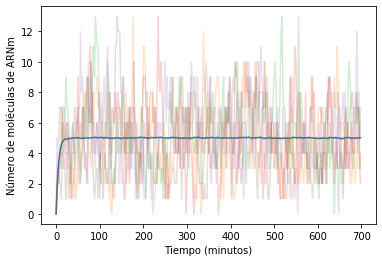

In [18]:
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Número de moléculas de ARNm')
plt.plot(celulas_prom[:,0],celulas_prom[:,1])
for i in range(5):
    plt.plot(celulas[i,:,0],celulas[i,:,1],alpha=0.2)

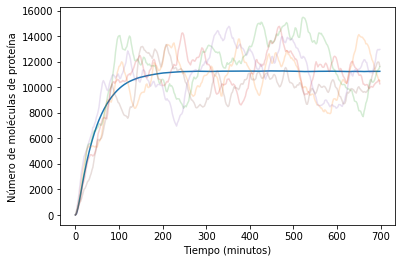

In [15]:
plt.xlabel('Tiempo (minutos)')
plt.ylabel('Número de moléculas de proteína')
plt.plot(celulas_prom[:,0],celulas_prom[:,2])
for i in range(5):
    plt.plot(celulas[i,:,0],celulas[i,:,2],alpha=0.2)